# import data from 86 files .nc4
- date: 2019-01-01  
  - variables:
    - latitudes
    - longitudes
    - CO2_std
    - CO2_sdev
  - dimensions:
    - time
    - lat
    - lon
  - attributes:
    - year
    - month
    - day
    - time

### Normailize data ???

In [1]:
# import libs
import os
import netCDF4 as nc4
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import itertools

In [3]:
# Ruta al directorio que contiene los archivos netCDF
directorio_archivos = 'descargas'
# Lista de archivos netCDF en el directorio
archivos_netCDF = [os.path.join(directorio_archivos, nombre_archivo) for nombre_archivo in os.listdir(directorio_archivos) if nombre_archivo.endswith('.nc4')]
# create a dict de dimensiones [91,144]
row = np.arange(0,91)
col = np.arange(0,144)
dict_dim = dict()

def media_armonica(valores):
    inversos = [1 / x for x in valores if x != 0]  # Calcula los inversos de los valores no iguales a 0
    if len(inversos) == 0:
        return 0  # Si no hay valores válidos, devuelve 0
    return len(inversos) / sum(inversos)

for i,j in itertools.product(row,col):
    dict_dim[(i,j)] = {"lat": [], "lon": [], "co2_std": [], "co2_sdev": []}
    # dict_dim[(i,j,"lon")] = []
    # dict_dim[(i,j,"co2_std")] = []
    # dict_dim[(i,j,"co2_sdev")] = []

for i in range(len(archivos_netCDF)):
    # Abre el archivo netCDF
    data = nc4.Dataset(archivos_netCDF[i],"r")

    latitude = data.variables['Latitude'][:]
    longitude = data.variables['Longitude'][:]
    co2_std = data.variables['mole_fraction_of_carbon_dioxide_in_free_troposphere'][:]
    co2_sdev = data.variables['mole_fraction_of_carbon_dioxide_in_free_troposphere_sdev'][:]
    # print(latitude)
    # print(longitude)
    # print(co2_std)
    # print(co2_sdev)
    lon, lat = np.meshgrid(longitude, latitude)

    # Aplana las mallas de coordenadas y la matriz de co2_free_troposphere a vectores unidimensionales
    lon_flat = lon #.flatten()
    lat_flat = lat #.flatten()
    # create data.fream
    df_lat = pd.DataFrame(lat_flat).fillna(0)
    df_lon = pd.DataFrame(lon_flat).fillna(0)
    df_co2_std = pd.DataFrame(co2_std).fillna(0)
    df_co2_sdev = pd.DataFrame(co2_sdev).fillna(0)




    for i,j in itertools.product(row,col):
        aux_lat = df_lat.iloc[i,j]
        dict_dim[(i,j)]["lat"].append(aux_lat)
        dict_dim[(i,j)]["lon"].append(df_lon.iloc[i,j])
        dict_dim[(i,j)]["co2_std"].append(df_co2_std.iloc[i,j])
        dict_dim[(i,j)]["co2_sdev"].append(df_co2_sdev.iloc[i,j])     

# Crear un data frame de los puntos unicos lat, lon para la dimension i,j
        
# print(dict_dim[(0,0)]["lat"])
columns = ["co2_std", "co2_sdev", "lat", "lon"]
df_dim = pd.DataFrame(columns=columns)
glat, glon = [], []
for i,j in itertools.product(row,col):
    # print(dict_dim[(i,j)]["lat"])
    # print(dict_dim[(i,j)]["lon"])
    # print(dict_dim[(i,j)]["co2_std"])
    # print(dict_dim[(i,j)]["co2_sdev"])
    # print("==================================")
    # print("==================================")
    # print("==================================")
    # print("=============================
    x = media_armonica(dict_dim[(i,j)]["co2_sdev"])
    y = media_armonica(dict_dim[(i,j)]["co2_std"])
    #print(pd.Series(dict_dim[(i,j)]["lat"]).unique()[0], pd.Series(dict_dim[(i,j)]["lon"]).unique()[0])
    glat.append(pd.Series(dict_dim[(i,j)]["lat"]).unique()[0]), glon.append(pd.Series(dict_dim[(i,j)]["lon"]).unique()[0])
    min_lat_lon = min([len(pd.Series(dict_dim[(i,j)]["lat"]).unique()),len(pd.Series(dict_dim[(i,j)]["lon"]).unique())])
    if min_lat_lon == 1:
        df_dim.loc[len(glat)-1] = [x, y, pd.Series(dict_dim[(i,j)]["lat"]).unique()[0], pd.Series(dict_dim[(i,j)]["lon"]).unique()[0]]
        # ({"co2_std": x, "co2_sdev": y, "lat": [pd.Series(dict_dim[(i,j)]["lat"]).unique()[0]], "lon": [pd.Series(dict_dim[(i,j)]["lon"]).unique()[0]]})
    else:
        df_dim.loc[len(glat)-1] = [x, y, pd.Series(dict_dim[(i,j)]["lat"]).unique()[0], pd.Series(dict_dim[(i,j)]["lon"]).unique()[0]]
        print("no es unico".upper().ljust(30,"="))
    # print()    
                

    
        # value.append(df_lat.iloc[i,j])
        # value.append(df_lon.iloc[i,j])



In [4]:
# normalize df_dim


In [5]:
#create a geodataframe with geopandas and shapely: lat, lon -> glat, glon 
#from matplotlib.patches import Polygon
#geometry = [gdp.Polygon(xy) for xy in zip(glon, glat)]
geometry = [Point(xy) for xy in zip(glon, glat)]
crs = 'EPSG:4326'
gdf = gpd.GeoDataFrame(df_dim, crs=crs, geometry=geometry)

In [6]:
min(df_dim["co2_std"]) 
float(max(df_dim["co2_std"]))
df_dim.query("co2_std >= 0.000005")

co2_std  co2_sdev   lat    lon
269  0.000005  0.000396  88.0  132.5

In [7]:
#describe the data
gdf.describe() 

co2_std      co2_sdev           lat           lon
count  13104.000000  13104.000000  13104.000000  13104.000000
mean       0.000002      0.000330     -0.005495     -1.250000
std        0.000001      0.000148     52.528319    103.924508
min        0.000000      0.000000    -90.000000   -180.000000
25%        0.000002      0.000394    -46.000000    -90.625000
50%        0.000003      0.000395      0.000000     -1.250000
75%        0.000003      0.000396     46.000000     88.125000
max        0.000005      0.000419     89.500000    177.500000

In [8]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 13104 entries, 0 to 13103
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   co2_std   13104 non-null  float64 
 1   co2_sdev  13104 non-null  float64 
 2   lat       13104 non-null  float64 
 3   lon       13104 non-null  float64 
 4   geometry  13104 non-null  geometry
dtypes: float64(4), geometry(1)
memory usage: 614.2 KB


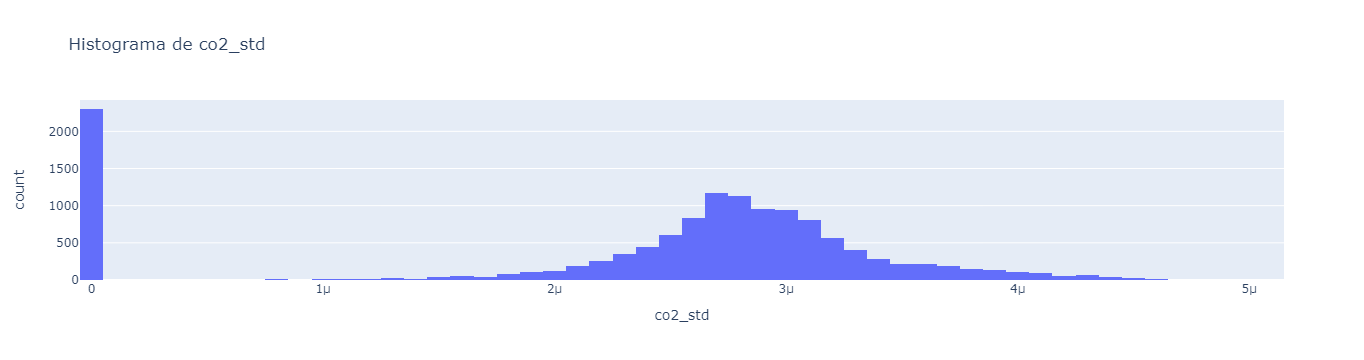

In [15]:
import plotly.express as px
fig = px.histogram(df_dim, x="co2_std", nbins=80, title="Histograma de co2_std")
fig.show()

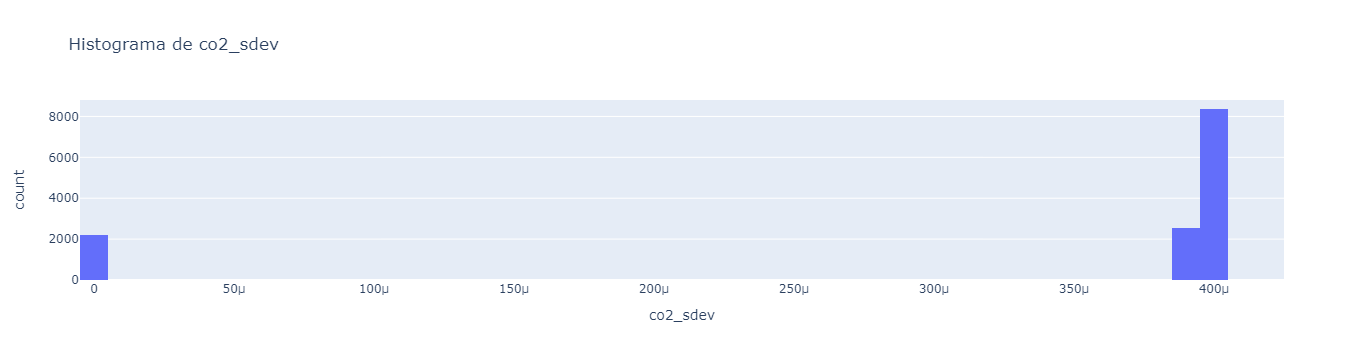

In [9]:
import plotly.express as px
fig = px.histogram(df_dim, x="co2_sdev", nbins=80, title="Histograma de co2_sdev")
fig.show()

## Basado en el segso observado en los graficos, optamos por eliminar valores donde co2_std -> 0

In [4]:
gdf2 = gdf.query("co2_std >= 0.000000001") #.plot(column='co2_std', cmap='OrRd', figsize=(15, 15), legend=True, scheme='quantiles')

NameError: name 'gdf' is not defined

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm


In [2]:
gdf2["co2_std"]

NameError: name 'gdf2' is not defined

/tmp/ipykernel_1443/3664182266.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



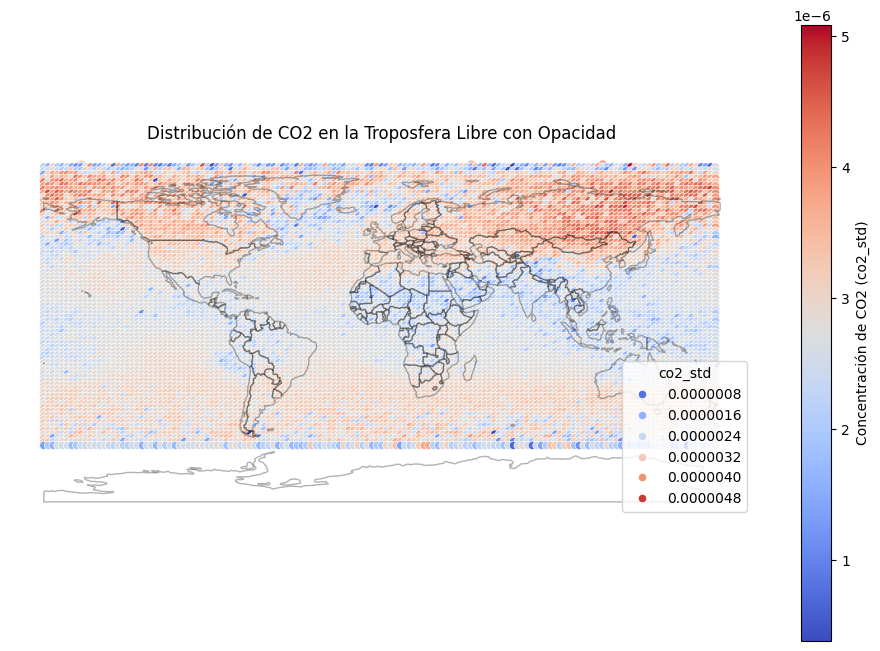

In [23]:

# Crea una figura de Matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Dibuja el mapa del mundo de GeoPandas como fondo
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, linewidth=1, color='black')

# Utiliza Seaborn para dibujar los puntos y personalizar la paleta de colores
sns.scatterplot(ax=ax,x= 'lon', y= 'lat', data = gdf2, hue = 'co2_std', palette='coolwarm')

# Agrega opacidad a los puntos para diferenciar la concentración
alpha = 0.3
ax.collections[0].set_alpha(alpha)

# Personaliza el aspecto del mapa
ax.set_title('Distribución de CO2 en la Troposfera Libre con Opacidad')
plt.axis('off')  # Desactiva los ejes

sm = cm.ScalarMappable(cmap='coolwarm')
sm.set_norm(mcolors.Normalize(vmin=min(gdf2["co2_std"]), vmax=max(gdf2["co2_std"])))
# Agrega una barra de colores (colorbar)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Concentración de CO2 (co2_std)')


# Muestra el mapa con los datos
plt.show()

/tmp/ipykernel_1443/1589977332.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



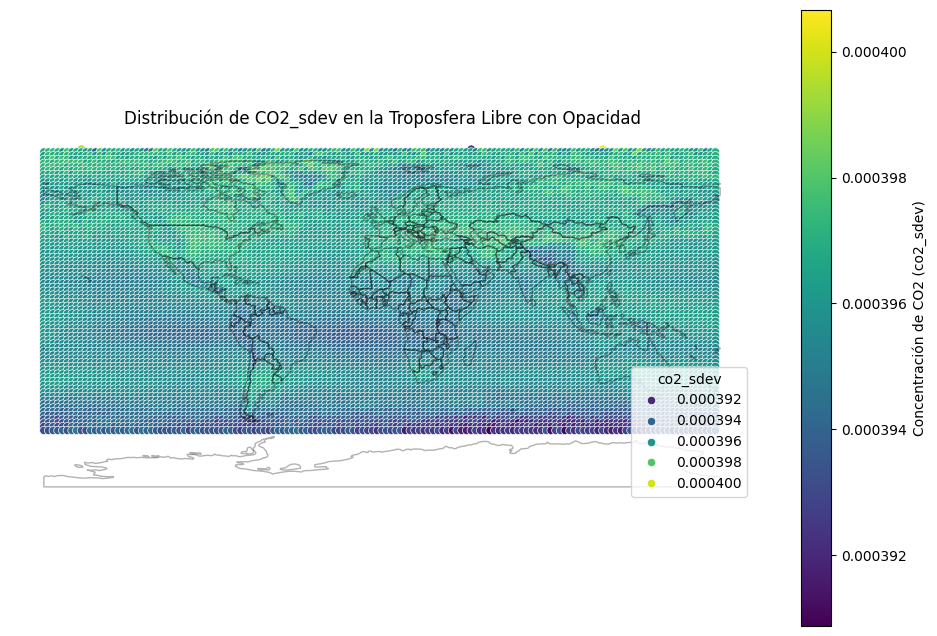

In [24]:
# Crea una figura de Matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Dibuja el mapa del mundo de GeoPandas como fondo
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, linewidth=1, color='black')

# Utiliza Seaborn para dibujar los puntos y personalizar la paleta de colores
sns.scatterplot(ax=ax,x= 'lon', y= 'lat', data = gdf2, hue = 'co2_sdev', palette='viridis')

# Agrega opacidad a los puntos para diferenciar la concentración
alpha = 0.3
ax.collections[0].set_alpha(alpha)

# Personaliza el aspecto del mapa
ax.set_title('Distribución de CO2_sdev en la Troposfera Libre con Opacidad')
plt.axis('off')  # Desactiva los ejes

sm = cm.ScalarMappable(cmap='viridis')
sm.set_norm(mcolors.Normalize(vmin=min(gdf2["co2_sdev"]), vmax=max(gdf2["co2_sdev"])))
# Agrega una barra de colores (colorbar)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Concentración de CO2 (co2_sdev)')


# Muestra el mapa con los datos
plt.show()